In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho']
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho']
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
h = dataset.variables['h']
h = np.transpose(h, (1, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

In [14]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

edata = eddies['Eddy15'].iloc[15]
t = extract_number(edata.name)

temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:
    fnumber = '0'+str(round(1461+ file_idx*30))
    
    temp = np.load('/srv/scratch/z5297792/Climatology/temps/temp_'+fnumber+'.npy') - np.repeat(temp_ave[:, :, :, np.newaxis], 30, axis=3)
    # temp = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy')
    # temp = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_'+fnumber+'.npy')
    previous_file_idx = file_idx

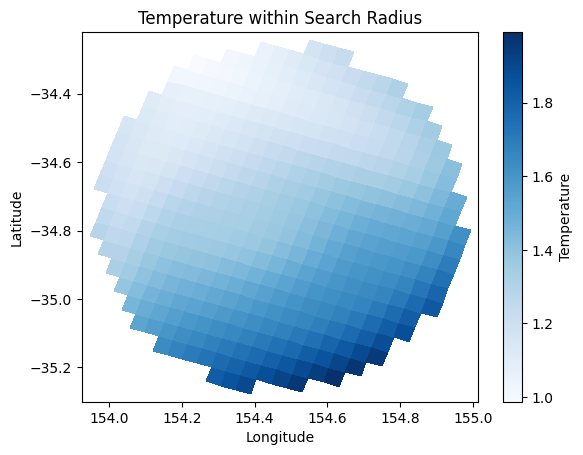

In [15]:
SEARCH_RADIUS = .5
R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
mask = R < SEARCH_RADIUS
temp_masked = np.where(mask, temp[:,:,3, t_mod], np.nan) 
colormap = 'Reds' if edata.Vort > 0 else 'Blues'

plt.pcolormesh(lon_rho, lat_rho, temp_masked, cmap=colormap)
plt.colorbar(label='Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Temperature within Search Radius')
plt.xlim([np.nanmin(np.where(mask,lon_rho,np.nan))-0.05,np.nanmax(np.where(mask,lon_rho,np.nan))+0.05])
plt.ylim([np.nanmin(np.where(mask,lat_rho,np.nan))-0.05,np.nanmax(np.where(mask,lat_rho,np.nan))+0.05])
plt.show()



## SSIM Method

In [16]:
import pandas as pd
from skimage.metrics import structural_similarity as ssim

def correlation_center_finder(grid1, grid2):
    def cycle_matrix_rows(matrix, shift):
        num_rows, num_cols = matrix.shape
        shift = shift % num_rows
        return np.vstack((matrix[-shift:], matrix[:-shift]))
    def cycle_matrix_columns(matrix, shift):
        num_rows, num_cols = matrix.shape
        shift = shift % num_cols
        return np.hstack((matrix[:, -shift:], matrix[:, :-shift]))
    def center_list(original_list):
        midpoint = (min(original_list) + max(original_list)) // 2
        centered_list = [x - midpoint for x in original_list]
        return centered_list

    def compare_matrices_ssim(matrix1, matrix2):
        if matrix1.shape != matrix2.shape:
            raise ValueError("Matrices must have the same dimensions for SSIM comparison.")
        data_range = matrix1.max() - matrix1.min()
        ssim_index, _ = ssim(matrix1, matrix2, data_range=data_range, full=True)
        return ssim_index

    I_vec = np.array(range(lon_rho.shape[0]))
    I_vec = I_vec.reshape(-1, 1)
    I = np.tile(I_vec, (1,lon_rho.shape[1]))
    J_vec = np.array(range(lon_rho.shape[1]))
    J = np.tile(J_vec, (lon_rho.shape[0], 1))

    num_rows = grid1.shape[0]
    num_cols = grid1.shape[1]

    xs = center_list(list(range(num_cols)))
    ys = center_list(list(range(num_rows)))

    R = []
    U = []
    C = []
    for x in xs:
        for y in ys:
            grid2_shifted = cycle_matrix_columns(cycle_matrix_rows(grid2, x),y)

            corr =compare_matrices_ssim(grid1, grid2_shifted)
            C.append(corr)
            # C.append(np.corrcoef(grid1.flatten(), grid2_shifted.flatten())[0, 1])

            R.append(x)
            U.append(y)
    df = pd.DataFrame({
        'Up': U,
        'Right' : R,
        'Correlation' : C
    })

    iU = df.iloc[np.argmax(df.Correlation)].Up
    iR = df.iloc[np.argmax(df.Correlation)].Right

    return df, iU, iR

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000  # in meters
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS * c

def extract_submatrix(matrix):
    non_nan_indices = np.argwhere(~np.isnan(matrix))
    min_row, min_col = np.min(non_nan_indices, axis=0)
    max_row, max_col = np.max(non_nan_indices, axis=0)
    submatrix = matrix[min_row:max_row+1, min_col:max_col+1]
    return submatrix

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    i_left = 0
    i_right = 0
    j_down = 0
    j_up = 0
    while (i_search - i_left >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search - i_left, j_search], lon_rho[i_search - i_left, j_search])) < SEARCH_WIDTH/2:
        i_left += 1
    while (i_search + i_right < lon_rho.shape[0] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search + i_right, j_search], lon_rho[i_search + i_right, j_search])) < SEARCH_WIDTH/2:
        i_right += 1
    while (j_search - j_down >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search, j_search - j_down], lon_rho[i_search, j_search - j_down])) < SEARCH_WIDTH/2:
        j_down += 1
    while (j_search + j_up < lon_rho.shape[1] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search, j_search + j_up], lon_rho[i_search, j_search + j_up])) < SEARCH_WIDTH/2:
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_up = min(j_search + j_up, lon_rho.shape[1])
    j_down = max(j_search - j_down + 1, 0)

    return i_left, i_right, j_down, j_up

In [17]:
import matplotlib.tri as tri
from scipy.interpolate import griddata

SEARCH_WIDTH = 50000

ics = []
jcs = []
surf_lon = edata.Lon
surf_lat = edata.Lat

depth_dics = {}

for depth_lvl in range(25):
    if depth_lvl == 0:
        R = np.sqrt((lon_rho - surf_lon)**2 + (lat_rho - surf_lat)**2)
    else:
        R = np.sqrt((lon_rho - c_lon)**2 + (lat_rho - c_lat)**2)

    i_search_lvl, j_search_lvl = np.argwhere(R == np.min(R))[0]

    i_left, i_right, j_down, j_up = grid_finder(i_search_lvl, j_search_lvl, SEARCH_WIDTH)
    
    temp_abv = temp[i_left:i_right, j_down:j_up, depth_lvl, t_mod]
    temp_blw = temp[i_left:i_right, j_down:j_up, depth_lvl + 1, t_mod]

    
    df, iU, iR = correlation_center_finder(temp_abv, temp_blw)

    ic = int(float(iR + i_search_lvl))
    jc = int(float(iU + j_search_lvl))

    df['i'] = df.Right + i_search_lvl
    df['j'] = df.Up + j_search_lvl

    xs = df.Right.to_numpy()
    ys = df.Up.to_numpy()
    values = df.Correlation.to_numpy()
    max_corr = float(np.nanmax(values))

    depth_dics['Depth'+str(depth_lvl)] = {'df': df, 'ic': ic, 'jc': jc, 'Max Correlation': max_corr, 'Depth': float(z_r[150,150,depth_lvl])}
                                                    
    ics.append(ic)
    jcs.append(jc)

    c_lon = lon_rho[ic,jc]
    c_lat = lat_rho[ic,jc]

R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]

theta0 = np.deg2rad(edata.Lon)
phi0 = np.deg2rad(edata.Lat)

for depth_dic in depth_dics:
    
    ix = depth_dics[depth_dic]['df'].i
    jy = depth_dics[depth_dic]['df'].j
    ic = depth_dics[depth_dic]['ic']
    jc = depth_dics[depth_dic]['jc']
    
    lons = lon_rho[ix, jy]
    lats = lat_rho[ix, jy]
    lonc = lon_rho[ic, jc]
    latc = lat_rho[ic, jc]
    
    lonr = np.deg2rad(lons)
    latr = np.deg2rad(lats)
    r_earth = 6371
    x = r_earth * np.cos(phi0) * (lonr - theta0)
    y = r_earth * (latr - phi0)
    
    xc = r_earth * np.cos(phi0) * (np.deg2rad(lonc) - theta0)
    yc = r_earth * (np.deg2rad(latc) - phi0)

    depth_dics[depth_dic]['df']['x'] = x
    depth_dics[depth_dic]['df']['y'] = y
    depth_dics[depth_dic]['xc'] = float(xc)
    depth_dics[depth_dic]['yc'] = float(yc)

    # Contour info
    p = depth_dics[depth_dic]['df'].Correlation
    xi = np.linspace(min(x), max(x), 100)
    yi = np.linspace(min(y), max(y), 100)
    xi, yi = np.meshgrid(xi, yi)
    pi = griddata((x, y), p, (xi, yi), method='cubic')
    contour_set = plt.contour(xi, yi, pi, levels=[.7])
    paths = contour_set.allsegs[0]
    plt.close() 
    depth_dics[depth_dic]['Contour Paths'] = paths


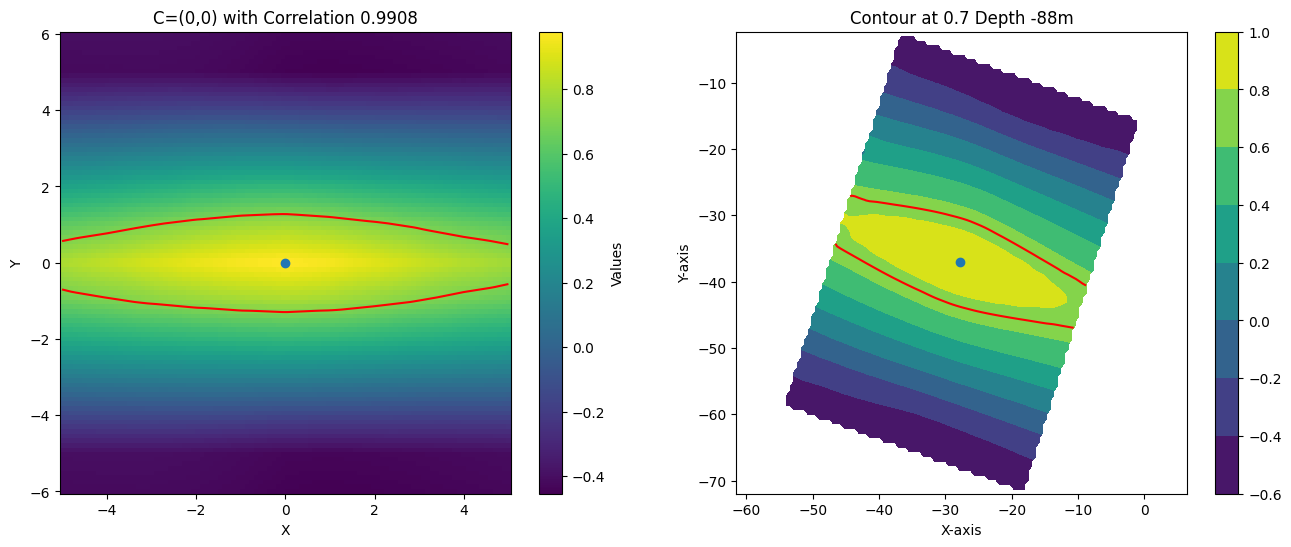

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

depth_dic = 'Depth10'

# Data for the first plot
df = depth_dics[depth_dic]['df']
xs = df.Right
ys = df.Up
values = df.Correlation

# Define the grid
x_grid = np.linspace(xs.min(), xs.max(), 100)
y_grid = np.linspace(ys.min(), ys.max(), 100)
X, Y = np.meshgrid(x_grid, y_grid)

# Interpolate the values onto the grid
Z = griddata((xs, ys), values, (X, Y), method='linear')

# Data for the second plot
x = depth_dics[depth_dic]['df'].x
y = depth_dics[depth_dic]['df'].y
d = depth_dics[depth_dic]['Depth']
p = depth_dics[depth_dic]['df'].Correlation
xc =  depth_dics[depth_dic]['xc']
yc =  depth_dics[depth_dic]['yc']

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

pi = griddata((x, y), p, (xi, yi), method='cubic')

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First plot
pcm = ax1.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
contour1 = ax1.contour(X, Y, Z, levels=[.7], colors='red', linestyles='-')
ax1.scatter(xs[np.argmax(values)], ys[np.argmax(values)])
fig.colorbar(pcm, ax=ax1, label='Values')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('C=(' + str(xs[np.argmax(values)]) + ',' + str(ys[np.argmax(values)]) + ') with Correlation ' + str(round(values[np.argmax(values)], 4)))

# Second plot
contourf = ax2.contourf(xi, yi, pi, cmap='viridis')
contour2 = ax2.contour(xi, yi, pi, levels=[.7], colors='red', linestyles='-')
fig.colorbar(contourf, ax=ax2)
ax2.scatter(xc, yc)
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
ax2.set_title('Contour at 0.7 Depth '+str(round(d))+'m')
ax2.axis('equal')

plt.show()


In [19]:
def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x, y

def rotate_30_clockwise(x, y):
    theta = np.deg2rad(30)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

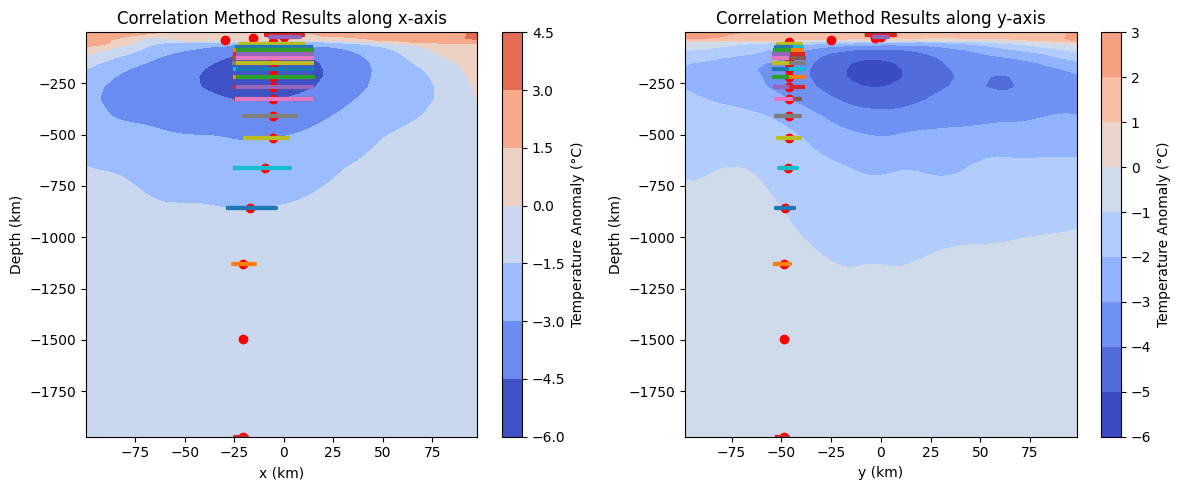

In [20]:
import matplotlib.colors as mcolors

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

DISPLAY_WIDTH = 200000
depth_lvl_limit = 25

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)

x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

x = x/1000
y = y/1000

xc_raw = []
yc_raw = []
zc = []
for depth_dic in depth_dics:
    xc_raw.append(depth_dics[depth_dic]['xc'])
    yc_raw.append(depth_dics[depth_dic]['yc'])
    zc.append(depth_dics[depth_dic]['Depth'])

    paths = depth_dics[depth_dic]['Contour Paths']
    depth = depth_dics[depth_dic]['Depth']

    for path in paths:
        vertices = np.array(path)
        vx, vy = vertices[:,0], vertices[:,1]
        vx, vy = rotate_30_clockwise(vx, vy)
        axs[0].plot(vx, [depth] * len(vx), linewidth=3)
        axs[1].plot(vy, [depth] * len(vy), linewidth=3)
        
xc, yc = rotate_30_clockwise(xc_raw, yc_raw)
z = z_r[150, 150, :depth_lvl_limit]

# First subplot
temp_anom_cross = temp[i_left:i_right, j_search, :depth_lvl_limit, t_mod]
X, Z = np.meshgrid(x, z)
temp_anom_data_range = np.nanmax(np.abs(temp_anom_cross))
c1 = axs[0].contourf(X, Z, temp_anom_cross.T, cmap='coolwarm', vmin=-temp_anom_data_range, vmax=temp_anom_data_range)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (km)')
axs[0].set_title('Correlation Method Results along x-axis')
fig.colorbar(c1, ax=axs[0], label='Temperature Anomaly (°C)')

axs[0].scatter(xc, zc, color='red')
# axs[0].plot(xc, zc, color='red', linewidth=2)

# Second subplot
temp_anom_cross = temp[i_search, j_down:j_up, :depth_lvl_limit, t_mod] 
Y, Z = np.meshgrid(y, z)
temp_anom_data_range = np.nanmax(np.abs(temp_anom_cross))
c2 = axs[1].contourf(Y, Z, temp_anom_cross.T, cmap='coolwarm', vmin=-temp_anom_data_range, vmax=temp_anom_data_range)
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (km)')
axs[1].set_title('Correlation Method Results along y-axis')
fig.colorbar(c2, ax=axs[1], label='Temperature Anomaly (°C)')

axs[1].scatter(yc, zc, color='red')
# axs[1].plot(yc, zc, color='red', linewidth=2)

plt.tight_layout()
plt.show()

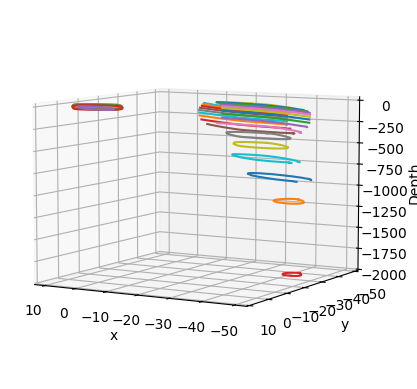

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for depth_dic in depth_dics:
    paths = depth_dics[depth_dic]['Contour Paths']
    depth = depth_dics[depth_dic]['Depth']

    for path in paths:
        vertices = np.array(path)
        ax.plot(vertices[:, 0], vertices[:, 1], [depth] * len(vertices[:, 0]))


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Depth')
ax.view_init(elev=7, azim=120)
plt.show()

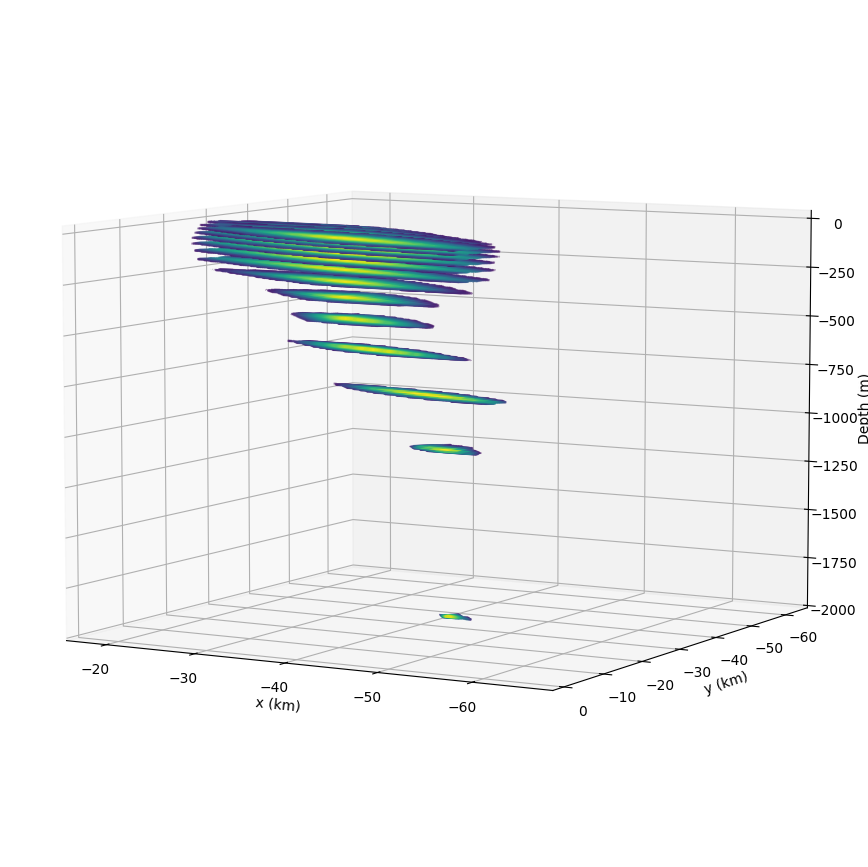

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

fig = plt.figure(figsize=(15, 11))
ax = fig.add_subplot(111, projection='3d')

xcs = []
ycs = []
depths = []
for depth_dic in depth_dics:
    x = depth_dics[depth_dic]['df'].x
    y = depth_dics[depth_dic]['df'].y

    values = depth_dics[depth_dic]['df'].Correlation
    
    xc = depth_dics[depth_dic]['xc']
    yc = depth_dics[depth_dic]['yc']
    
    x_grid = np.linspace(x.min(), x.max(), 100)
    y_grid = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    
    Z = griddata((x, y), values, (X, Y), method='linear')

    depth = depth_dics[depth_dic]['Depth']
    depths.append(depth)
    
    Z_filtered = np.where(Z > 0.7, Z, np.nan)
    
    ax.plot_surface(X, Y, Z_filtered + depth, cmap='viridis', edgecolor='none', alpha=0.7)
    ax.contour3D(X, Y, Z_filtered + depth, 50, cmap='viridis', alpha=0.5)
    
# ax.plot(xcs, ycs, depths, color='red')

ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth (m)')


ax.view_init(elev=7, azim=120)  # Adjust elev (elevation) and azim (azimuthal) as needed #10-220

ax.set_xlim(x.min(), x.max())  
ax.set_ylim(y.min(), y.max())  
# ax.set_zlim(depth - 5, depth + 5)  


plt.show()


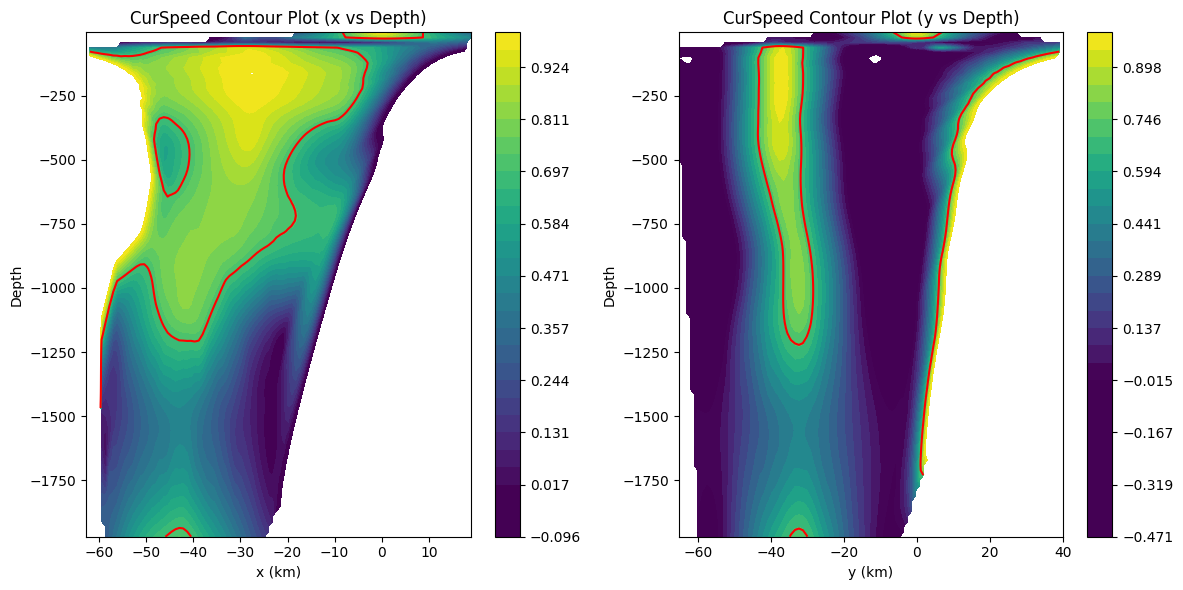

In [23]:
# Subplot 1: x vs depth
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Data preparation for x axis plot
xs = []
ds = []
ps = []
for depth_dic in depth_dics:
    x = depth_dics[depth_dic]['df']['x']
    d = [depth_dics[depth_dic]['Depth']] * len(x)
    p = depth_dics[depth_dic]['df']['Correlation']

    j = depth_dics[depth_dic]['df']['j']
    jc = depth_dics[depth_dic]['jc']

    col_idx = j == jc

    x = [x[i] for i in range(len(x)) if col_idx[i]]
    d = [d[i] for i in range(len(d)) if col_idx[i]]
    p = [p[i] for i in range(len(p)) if col_idx[i]]

    xs.extend(x)
    ds.extend(d)
    ps.extend(p)

x = xs
y = ds
p = ps

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)
pi = griddata((x, y), p, (xi, yi), method='cubic')

levels = np.linspace(min(p), max(p), 30)
contourf = axs[0].contourf(xi, yi, pi, levels=levels, cmap='viridis', vmin=0, vmax=1)
contour = axs[0].contour(xi, yi, pi, levels=[0.7], colors='red')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth')
axs[0].set_title('CurSpeed Contour Plot (x vs Depth)')
plt.colorbar(contourf, ax=axs[0])

# Data preparation for y axis plot
ys = []
ds = []
ps = []
for depth_dic in depth_dics:
    y = depth_dics[depth_dic]['df']['y']
    d = [depth_dics[depth_dic]['Depth']] * len(y)
    p = depth_dics[depth_dic]['df']['Correlation']

    i = depth_dics[depth_dic]['df']['i']
    ic = depth_dics[depth_dic]['ic']

    row_idx = i == ic

    y = [y[i] for i in range(len(y)) if row_idx[i]]
    d = [d[i] for i in range(len(d)) if row_idx[i]]
    p = [p[i] for i in range(len(p)) if row_idx[i]]

    ys.extend(y)
    ds.extend(d)
    ps.extend(p)

x = ys
y = ds
p = ps

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)
pi = griddata((x, y), p, (xi, yi), method='cubic')

levels = np.linspace(min(p), max(p), 30)
contourf = axs[1].contourf(xi, yi, pi, levels=levels, cmap='viridis', vmin=0, vmax=1)
contour = axs[1].contour(xi, yi, pi, levels=[0.7], colors='red')
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth')
axs[1].set_title('CurSpeed Contour Plot (y vs Depth)')
plt.colorbar(contourf, ax=axs[1])

plt.tight_layout()
plt.show()

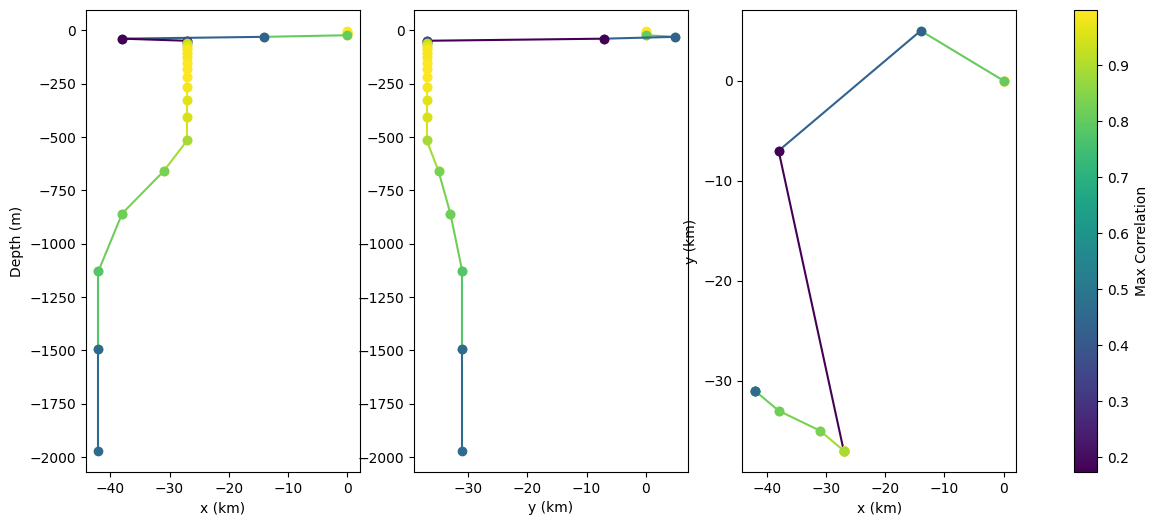

In [24]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

x = []
y = []
max_corrs = []
e_depths = []
for depth_dic in depth_dics:
    x.append(int(depth_dics[depth_dic]['xc']))
    y.append(int(depth_dics[depth_dic]['yc']))
    max_corrs.append(depth_dics[depth_dic]['Max Correlation'])
    e_depths.append(depth_dics[depth_dic]['Depth'])

norm = mcolors.Normalize(vmin=min(max_corrs), vmax=max(max_corrs))
cmap = plt.colormaps.get_cmap('viridis')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

for i in range(len(ics) - 1):
    color = cmap(norm(max_corrs[i]))
    ax1.plot(x[i:i+2], e_depths[i:i+2], marker='o', color=color)
    ax2.plot(y[i:i+2], e_depths[i:i+2], marker='o', color=color)
    ax3.plot(x[i:i+2], y[i:i+2], marker='o', color=color)

ax1.set_xlabel('x (km)')
ax1.set_ylabel('Depth (m)')
ax2.set_xlabel('y (km)')
# ax2.set_ylabel('Depth (m)')
ax3.set_xlabel('x (km)')
ax3.set_ylabel('y (km)')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=[ax1, ax2, ax3], orientation='vertical', label='Max Correlation')

# plt.tight_layout()
plt.show()